In [1]:
# define the CO cube and HI map paths
# VCC1581 CO cube
co_cube_path = "VCC1581_7m_co21_pbcorr_round_k.fits"

# VCC1581 is the smaller galaxy in the lower left of the VIVA HI moment
hi_mom1_path = "NGC4532_reprojected_15_arcsec_mom1.fits"
# hi_mom1_path = "/Users/thbrown/VERTICO/share/multiwavelength/viva/public_data/viva-mom1-fits/ngc4532.mom1.fits"

In [2]:
from astropy import units as u
from spectral_cube import SpectralCube
from stackarator import stackarator
from astropy.convolution import Gaussian1DKernel

cube = SpectralCube.read(co_cube_path).with_spectral_unit(u.km / u.s)

kernel = Gaussian1DKernel(7)
cube = cube.spectral_smooth(kernel)

nchan = len(cube.spectral_axis)
cube_rms = (cube[: int(nchan / 4)].std() + cube[: int(nchan / 4)].std()) / 2

stack = stackarator()
stack.read_fits_cube(co_cube_path, rms=cube_rms.value)

Use KinMS to see what our galaxy looks like.

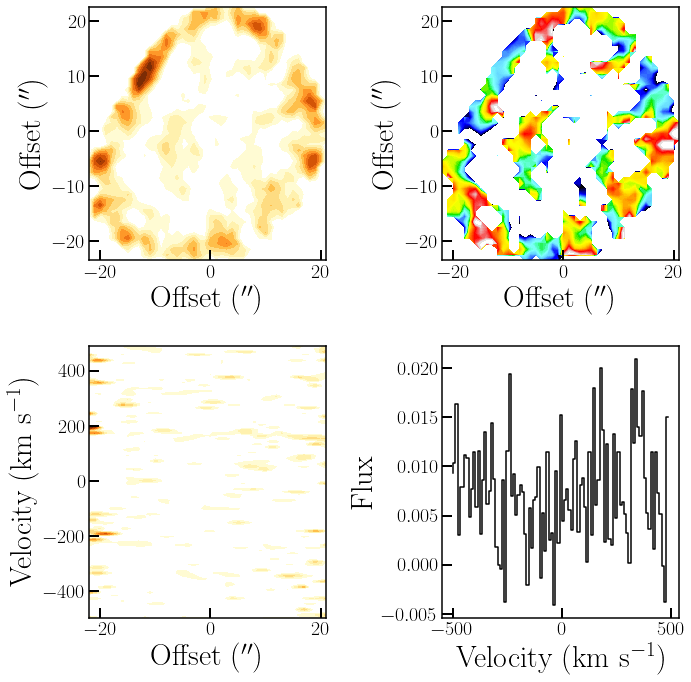

In [3]:
from kinms.utils.KinMS_figures import (
    KinMS_plotter,
)  # just for making nice plots

KinMS_plotter(
    stack.datacube,
    stack.xcoord.size,
    stack.ycoord.size,
    stack.vcoord.size * stack.dv,
    1,
    stack.dv,
    [stack.bmaj, stack.bmin, stack.bpa],
    posang=329,
).makeplots()

# HI moment 1 cutout
Since the HI moment map FOV is huge, we create cutout of VCC1581's velocity field

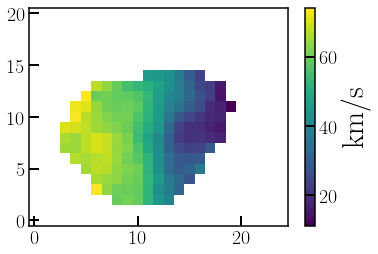

In [4]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.pyplot as plt

large_hi_mom1_data, large_hi_mom1_hdr = fits.getdata(hi_mom1_path, header=True)
# large_hi_mom1_data = large_hi_mom1_data[0,:,:]

# optical position
vcc1581_position = SkyCoord("+12h34m45.05s +6d18m03.24s", frame="icrs")

# optical size
kron_radius = 40 * u.arcsec
cutout_size = kron_radius * 5

cutout = Cutout2D(
    large_hi_mom1_data,
    vcc1581_position,
    size=cutout_size,
    wcs=WCS(large_hi_mom1_hdr).celestial,
)

plt.imshow(cutout.data, origin="lower")
plt.colorbar(label='km/s')

In [5]:
# save to new fits file
hdu = fits.PrimaryHDU(cutout.data, header=large_hi_mom1_hdr)
# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header())
hdu.writeto("VCC1581_hi_mom1.fits", overwrite=True)


Now we can read in the velocity field we want to use to stack the data. This doesnt have to be evaluated on the same pixel grid, or even observed at the same resolution, as 2D interpolation is used to match it to the datacube. 

In [6]:
# resession velocity
vel = 2040 # km/s
stack.read_fits_mom1("VCC1581_hi_mom1.fits", vsys=vel)

vout, outspec, outrms, outn = stack.stack()

100%|██████████| 2068/2068 [00:00<00:00, 15572.17it/s]


plot stacked spectra

Text(0, 0.5, 'Intensity [K]')

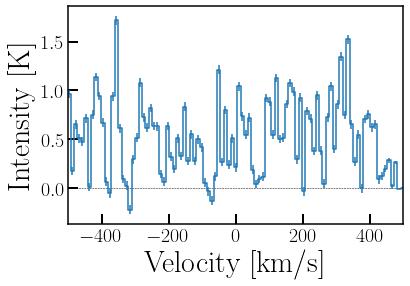

In [7]:
# set up the figure 
fig = plt.figure()
ax = fig.add_subplot()

ax.errorbar(vout, outspec, yerr=outrms, drawstyle="steps-mid")
ax.set_xlim(-500, 500)
ax.hlines(0, -500, 500, colors="k", ls="--", lw=0.5, zorder=0)
ax.set_xlabel("Velocity [km/s]")
ax.set_ylabel("Intensity [K]")
# plt.legend()

As you can see we are able to retrive the signal buried in the noisy data. Stackarator provides us with uncertanty estimates for each channel, and indicates the number of spaxels summed (the `outn` variable above). 

### Elliptical apertures

Stackarator can define elliptical regions to conduct our stacking within. 
In the code below we will take advantage of this to stack the spectra in different annuli with width = 1 beam

100%|██████████| 220/220 [00:00<00:00, 14439.35it/s]


Text(0, 0.5, 'K')

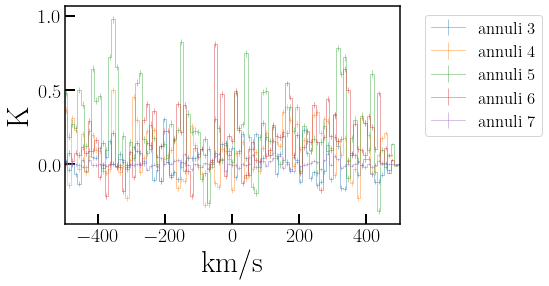

In [20]:
from astropy.io import fits

gal_centre = [
    fits.getheader(co_cube_path)["OBSRA"],
    fits.getheader(co_cube_path)["OBSDEC"],
]  # RA and Dec galaxy centre

inc = 0  # inclination
pa = 0  # position angle
beam_size = fits.getheader(co_cube_path)["BMAJ"] * 3600

# set up the figure formatter
fig = plt.figure()
ax = fig.add_subplot()

surface_brightness_profile = []
e_surface_brightness_profile = []

for i in range(2,7):

    ## stack the galaxy in beam size annuli
    stack.define_region_ellipse(
        gal_centre,
        inc,
        pa,
        rad_inner=i * beam_size,
        rad_outer=(i + 1) * beam_size,
    )
    vout_annuli, outspec_annuli, outrms_annuli, outn_annuli = stack.stack()

    ax.errorbar(
        vout_annuli,
        outspec_annuli,
        yerr=outrms_annuli,
        drawstyle="steps-mid",
        lw=0.8,
        alpha=0.5,
        label="annuli " + str(i + 1),
    )

    # sum the flux in the annuli
    surface_brightness_profile.append(outspec_annuli.sum() * stack.dv)
    e_surface_brightness_profile.append(outrms_annuli.mean() * stack.dv)

ax.set_xlim(-500, 500)
ax.legend(fontsize="small", loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_xlabel("km/s")
ax.set_ylabel("K")

Text(0, 0.5, 'surface brightness [K km/s]')

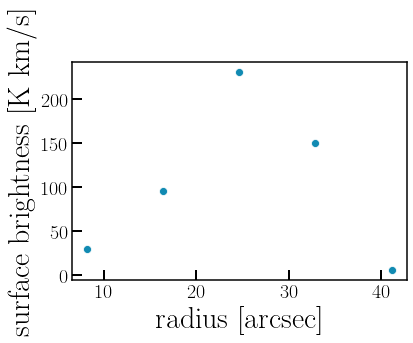

In [21]:
import numpy as np

# set up the figure formatter
fig = plt.figure()
ax = fig.add_subplot()

ax.errorbar(
    (np.arange(len(surface_brightness_profile)) + 1) * beam_size,
    surface_brightness_profile,
    yerr=e_surface_brightness_profile,
    marker="o",
    ms=8,
    markeredgecolor="white",
    markeredgewidth=0.75,
    linestyle="None",
    color="#118AB2",
    elinewidth=2.5,
    capthick=0.5,
    zorder=10,
)

ax.set_xlabel("radius [arcsec]")
ax.set_ylabel("surface brightness [K km/s]")